# Exercise 1
#### Group 25. Maximilian Laurent Heß (12347554), Oleksandra Kravchenko (11935050)
The goal of this notebook is to:
- prepare the NBA data by merging different data sources
- handling duplicates and missing values
- grouping data to create new datasets
- creating visualisations with processed data
- saving the data for the next assignment

## Reading the data

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool, Legend
from bokeh.models.formatters import CustomJSTickFormatter
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

We have the following data files:
- **players**: information about individual players
- **teams**: general information about NBA teams
- **player_data_per_36_min**: quantitive data about each player's performance in a given season. Players' performance is normalized to 36-minutes-game for more objective comparison regardless of playing time.

In [80]:
players = pd.read_csv("data/players.csv")
teams = pd.read_csv("data/teams.csv")
player_data_per_36_min = pd.read_csv("data/player_data_per_36_min.csv")

## Handling duplicates
First, we check for any total duplicates in the data.

In [81]:
print(
    f"Duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated()])}"
)
print(f"Duplicates in players.csv: {len(players[players.duplicated()])}")
print(f"Duplicates in teams.csv: {len(teams[teams.duplicated()])}")

Duplicates in player_data_per_36_min.csv: 0
Duplicates in players.csv: 0
Duplicates in teams.csv: 0


We do not have any complete duplicates in our data. However, we noticed that the player_data_per_36_min dataset contains multiple entries per player_id per season, which does not support our initial assumption about the content of the data. 
After further research in the data source, we found out, that NBA players often switch teams, so many players would have multiple entries for the same season while they played for different teams. Besides, where it is the case, there is also an additional row with the "total" statistics for the player across the teams that matches the same of total games from other 2 entries for the player for different teams. Technically, this behaviour makes the rows with total statistics a duplicate because they do not provide any additional data but only summarize the other entries.

Since we do not have any information about the specific team that any given player's performance is attributed to (there is no team_id column in the player_data_per_36_min dataset), we decided to only keep the "total" statistics (identified by the maximum value of "total_games"). The cells below provide an example.

In [82]:
print(
    f"Partial duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])])}"
)

Partial duplicates in player_data_per_36_min.csv: 4780


In [83]:
player_data_per_36_min.loc[
    (player_data_per_36_min["player_id"] == 1)
    & (player_data_per_36_min["season"] == "1994-95")
]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
11870,11871,1,1994-95,54.0,0.0,506.0,8.4,16.4,0.511,0.0,...,0.571,2.6,5.5,8.1,0.9,1.1,0.9,3.2,7.4,18.2
11871,11872,1,1994-95,51.0,0.0,476.0,8.8,16.6,0.532,0.0,...,0.571,2.6,5.4,8.0,1.0,1.1,0.9,3.0,7.7,19.2
11872,11873,1,1994-95,3.0,0.0,30.0,1.2,13.2,0.091,0.0,...,NaN,3.6,6.0,9.6,0.0,0.0,0.0,6.0,2.4,2.4


In [84]:
player_data_per_36_min.loc[
    (player_data_per_36_min["player_id"] == 4794)
    & (player_data_per_36_min["season"] == "2018-19")
]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
26067,26068,4794,2018-19,59.0,37.0,1040.0,7.3,13.1,0.559,0.0,...,0.802,4.0,8.6,12.5,2.2,0.5,1.8,2.4,4.7,18.2
26068,26069,4794,2018-19,33.0,12.0,516.0,7.8,13.5,0.580,0.0,...,0.864,3.8,7.5,11.3,1.7,0.3,1.9,2.3,5.1,19.6
26069,26070,4794,2018-19,26.0,25.0,524.0,6.9,12.8,0.538,0.0,...,0.733,4.2,9.5,13.7,2.6,0.7,1.6,2.5,4.4,16.8


In [85]:
# sort the values by total games played - small to large
# remove duplicates for season and player_id and keep only the largest value of total_games
player_data_per_36_min = (
    player_data_per_36_min.sort_values("total_games")
    .drop_duplicates(["season", "player_id"], keep="last")
    .sort_index()
)
print(
    f"Partial duplicates in player_data_per_36_min.csv after duplicate removal: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])])}"
)

Partial duplicates in player_data_per_36_min.csv after duplicate removal: 0


There are no duplicate IDs in players and teams datasets, so it is safe to proceed to the next step of merging the data on these IDs.

In [86]:
print(f"Duplicate id's in players.csv: {len(players[players.duplicated(["id"])])}")
print(f"Duplicate id's in teams.csv: {len(teams[teams.duplicated(["team_id"])])}")

Duplicate id's in players.csv: 0
Duplicate id's in teams.csv: 0


## Data structuring
### Merging the data

First, we join the data from players dataset with players' statistics stored in players_data_per_36_min. This way, we get an expanded players' statistics dataset with not only player_id but also other relevant player-specific information. 

In [87]:
# players + player_data_per_36_min
df_helper = players.merge(
    player_data_per_36_min,
    how="right",  # right join due to 1:n relationship
    left_on="id",
    right_on="player_id",
)

Now, we join the intermediate df_helper containing players data with the teams data. From the teams dataset we only want to include the team name based on the current team the player belongs to. Since we cannot tell to which team every player belonged at any point in his career, the past performance statistics of every player will be attributed to his current team. We do not plan to analyze the teams' performances in detail, so we can keep working with this assumption, though it does impact the factual integrity of the data, especially considering the fact that most players in the dataset are already retired.

In [88]:
df_merged = df_helper.merge(
    teams[["team_name", "team_id"]],
    how="left",  # left join due to n:1 relationship
    left_on="current_team_id",
    right_on="team_id",
)

### Handling different data formats
Some of the numeric attributes are formatted as objects but it would be easier to work with them as thei respective data types.
We decided to solve this for the following attributes:
- height: given in feet and inches -> convert to inches
- birth_date: given as a string -> convert to date

In [89]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21894 entries, 0 to 21893
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_x             21894 non-null  int64  
 1   name             21894 non-null  object 
 2   full_name        21894 non-null  object 
 3   position         21894 non-null  object 
 4   height           21894 non-null  object 
 5   weight           21891 non-null  float64
 6   birth_date       21893 non-null  object 
 7   birth_place      21563 non-null  object 
 8   retired          21894 non-null  bool   
 9   player_url       21894 non-null  object 
 10  current_team_id  2406 non-null   float64
 11  teams            21894 non-null  object 
 12  text             21894 non-null  object 
 13  id_y             21894 non-null  int64  
 14  player_id        21894 non-null  int64  
 15  season           21894 non-null  object 
 16  total_games      21881 non-null  float64
 17  games_starte

In [90]:
# define the function to convert feet and inches to just inches
def feet_to_inches(height):
    feet, inches = map(int, height.split("-"))
    return feet * 12 + inches


# apply the conversion function
df_merged["height_inches"] = df_merged["height"].apply(feet_to_inches)

In [91]:
# convert birth date to date format
df_merged["birth_date"] = pd.to_datetime(df_merged["birth_date"], format="%B %d %Y")

## Handling Nulls

 ### Drop unnecessary columns 
- id_x, id_y were only used for merging and are redundant
- player_url and text will not be used for any data processing or visualisations 
- team_id and current_team_id are redundant because team names are unique (unlike the players' names), so we will not need the IDs for any visualisations, only the team names
- original height column is redundant because it was converted to inches in the previous section

In [92]:
df_merged = (
    df_merged.drop(
        columns=["id_x", "id_y", "player_url", "team_id", "current_team_id", "height", "text"]
    )
    .sort_values(by="player_id")
    .reset_index(drop=True)
)

### Visual representation of Nulls

To get a feeling for the amounts of nulls and their distribution in the dataset, we create some plots.

Text(0.5, 1.0, 'Percentage of null values per column (0 % excluded)')

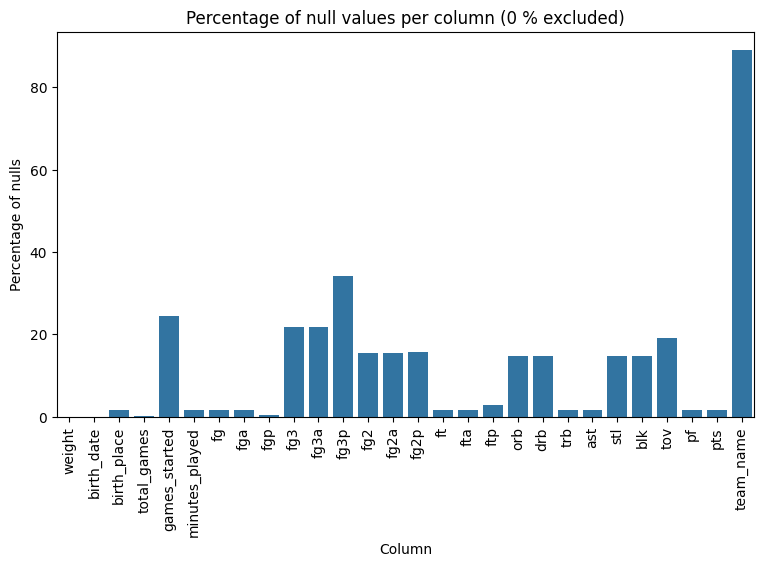

In [93]:
# don't visualize all columns that are zero as there is no need to visualise them
df_null_plot = df_merged.loc[:, df_merged.isnull().sum() != 0]
null_per_column = df_null_plot.isnull().sum()
percentage_per_column = null_per_column / len(df_null_plot) * 100
percentage_per_column.apply(lambda x: f"{np.round(x,2)} %")

plt.figure(figsize=(9, 5))
ax = sns.barplot(percentage_per_column)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Percentage of nulls")
ax.set_xlabel("Column")
ax.set_title("Percentage of null values per column (0 % excluded)")

From the plot above, we see a massive outlier with over 80% of missing values, the team_name column. The player statistics are all also missing values, though it may be possible to impute them based on other values. Some of the columns like weight, birth_date are missing just a few values, and so they can potentially be reliably imputed manually. We will deal with different columns separately to restore as much data as possible and analyse in detail why certain values might be missing. 

Additionally, we generate a heatmap of null values to visually represent their distribution across the rows of the dataset.

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

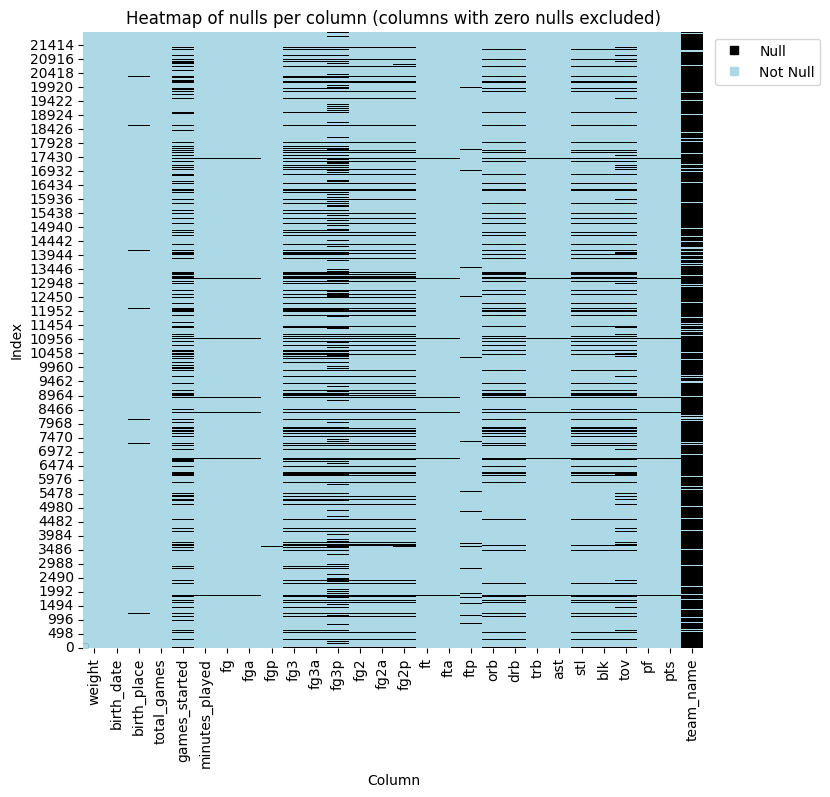

In [94]:
colors = ["lightblue", "black"]
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_null_plot.isnull(), cmap=colors, cbar=False)

plt.plot([0], label="Null", color=colors[1], marker="s", linestyle="")
plt.plot([0], label="Not Null", color=colors[0], marker="s", linestyle="")
legend = plt.legend(bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

In the plot above, the y-axis represents the indices of records, while the x-axis represents the columns. We can notice from this visualization, that in some rows, nearly all player statistics are missing, so it might be harder to handle those missing values.

Further, we are investigating the numeric variables that can be imputed using an appropriate function. We first filter the data for only numeric variables and then plot a scatter matrix to investigate how the existing values are distributed and whether they are correlated with other attributes in the dataset and that can be used a reference values for imputation.

array([[<Axes: xlabel='minutes_played', ylabel='minutes_played'>,
        <Axes: xlabel='games_started', ylabel='minutes_played'>,
        <Axes: xlabel='total_games', ylabel='minutes_played'>,
        <Axes: xlabel='fg', ylabel='minutes_played'>,
        <Axes: xlabel='fga', ylabel='minutes_played'>,
        <Axes: xlabel='fgp', ylabel='minutes_played'>,
        <Axes: xlabel='fg3', ylabel='minutes_played'>,
        <Axes: xlabel='fg3a', ylabel='minutes_played'>,
        <Axes: xlabel='fg3p', ylabel='minutes_played'>,
        <Axes: xlabel='fg2', ylabel='minutes_played'>,
        <Axes: xlabel='ft', ylabel='minutes_played'>,
        <Axes: xlabel='fta', ylabel='minutes_played'>,
        <Axes: xlabel='ftp', ylabel='minutes_played'>,
        <Axes: xlabel='orb', ylabel='minutes_played'>,
        <Axes: xlabel='drb', ylabel='minutes_played'>,
        <Axes: xlabel='trb', ylabel='minutes_played'>,
        <Axes: xlabel='ast', ylabel='minutes_played'>,
        <Axes: xlabel='stl', ylabel=

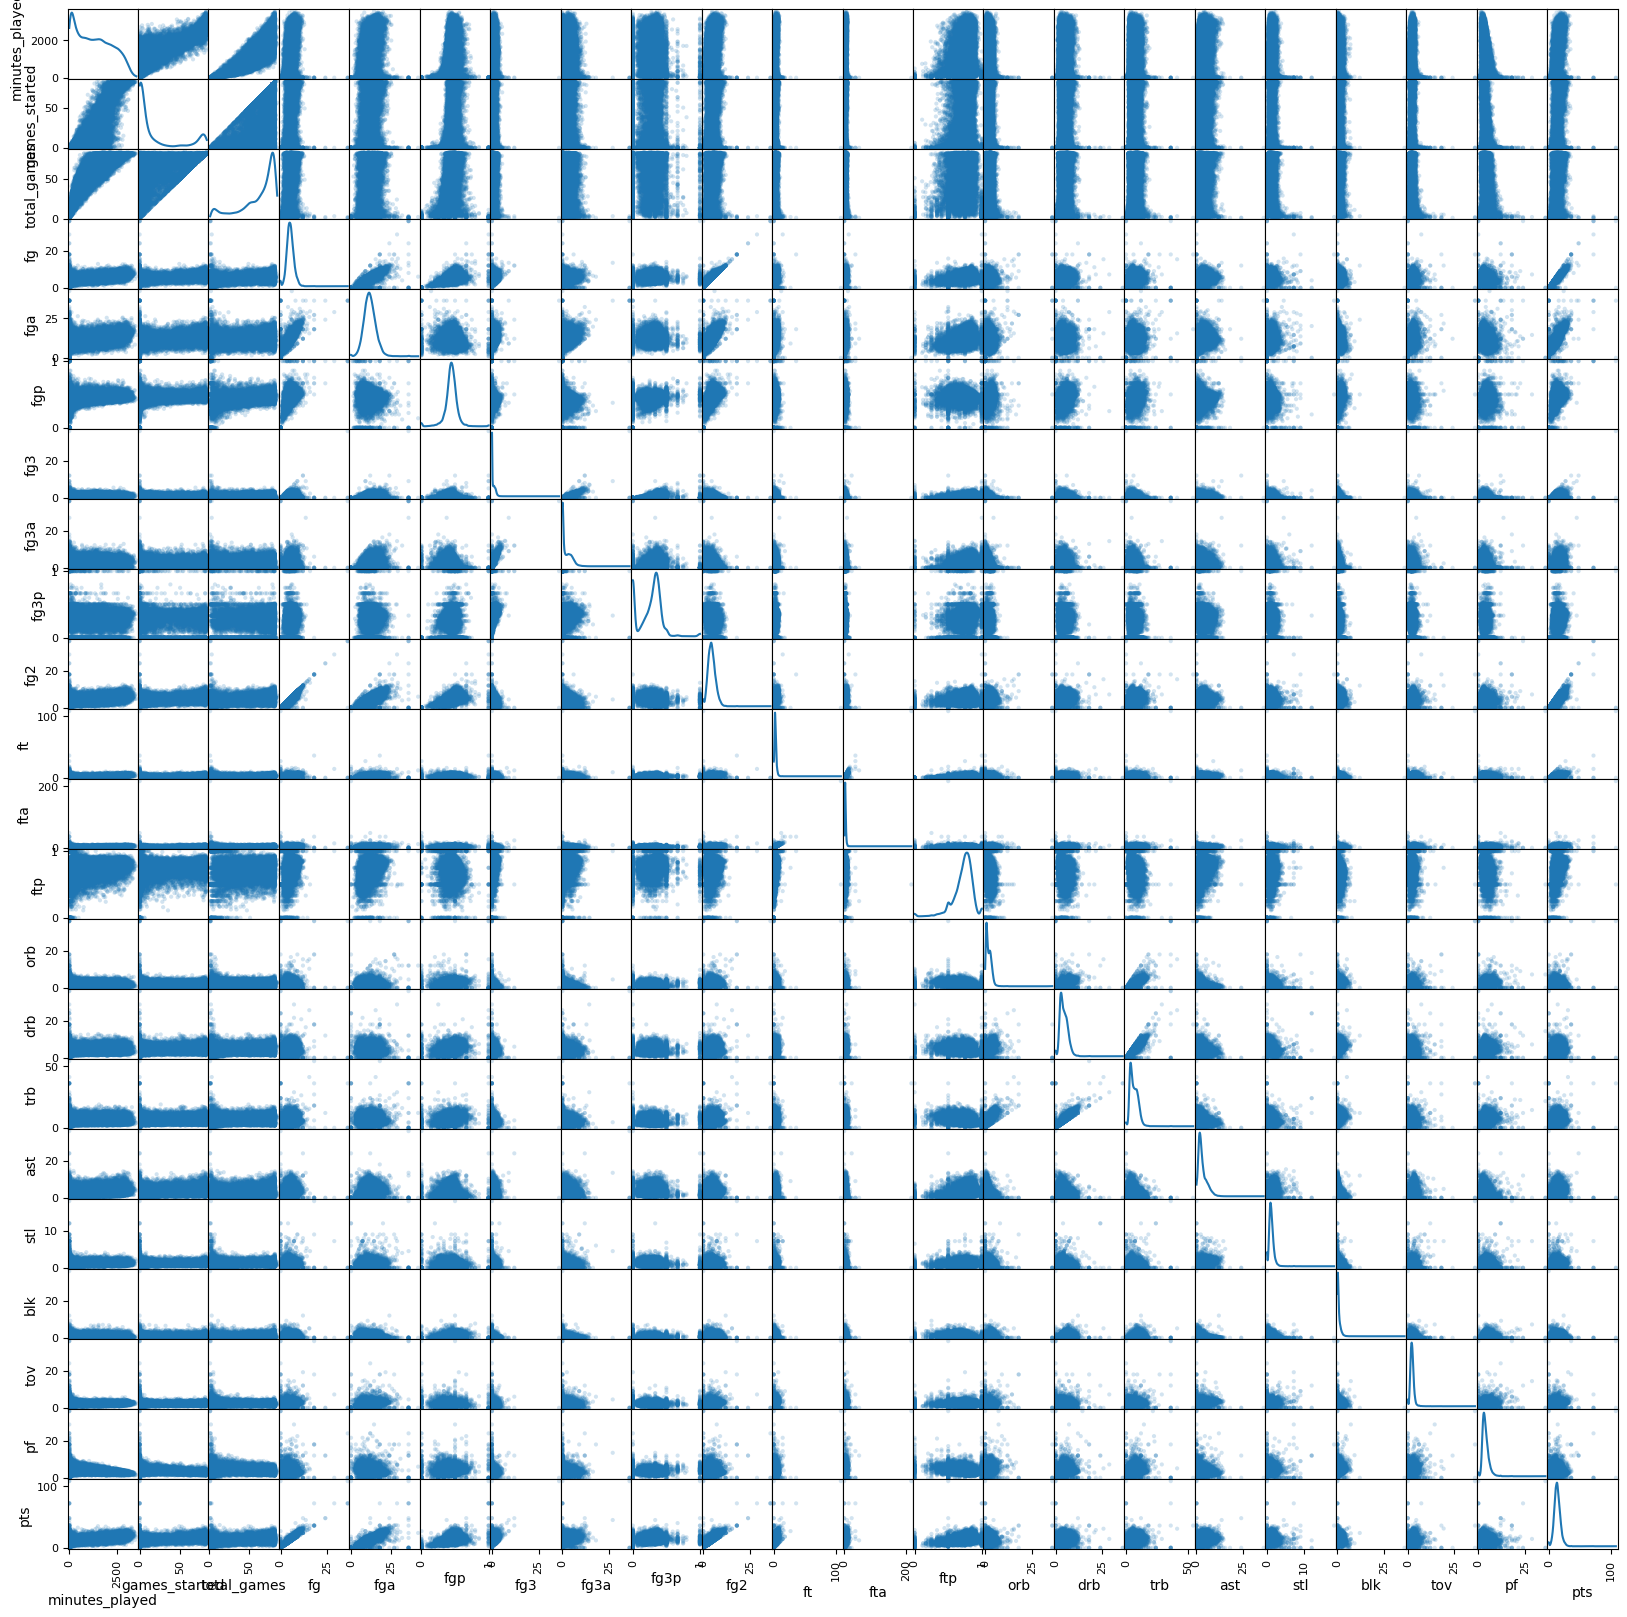

In [ ]:
sct_data = df_post_3_point_line[["minutes_played", "games_started", "total_games", "fg", "fga", "fgp", "fg3", "fg3a", "fg3p", "fg2", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pf", "pts"]]
scatter_matrix(sct_data, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')

The scatter matrix above provides us with good general understanding for the distributions of different numeric attributes and their correlation. Unfortunately, it is hard to derive any reliable correlation between the attributes. Most attributes are not correlated, though we notice that number of points (pts) is stronger correlated with field goals (fg, fg2) and different types of field goals are correlated with each other. 
Naturally, this is how one scores points in basketball, so the correlation is easily explainable. One exception is the variable fg3, the 3-point field goals. We do not notice this correlation with point and other field goals here because there are more rarely attempted and have a higher percentage of missing values in the data. 

The same observation can be made for total rebounds (trb) and offensive and defensive rebounds (orb,drb). The total rebounds just sums up the types of rebounds, so the correlation is also explainable.

The games started are also naturally correlated with minutes played and total games.

In [ ]:
#sct_data.corr()
# uncomment for numbers

The correlation matrix even better represents the degree of correlation between variables than the plot above. We can conclude that the correlation between most variables that require missing values imputation is negligable and we will continue imputing the players' statistics based on other assumptions.

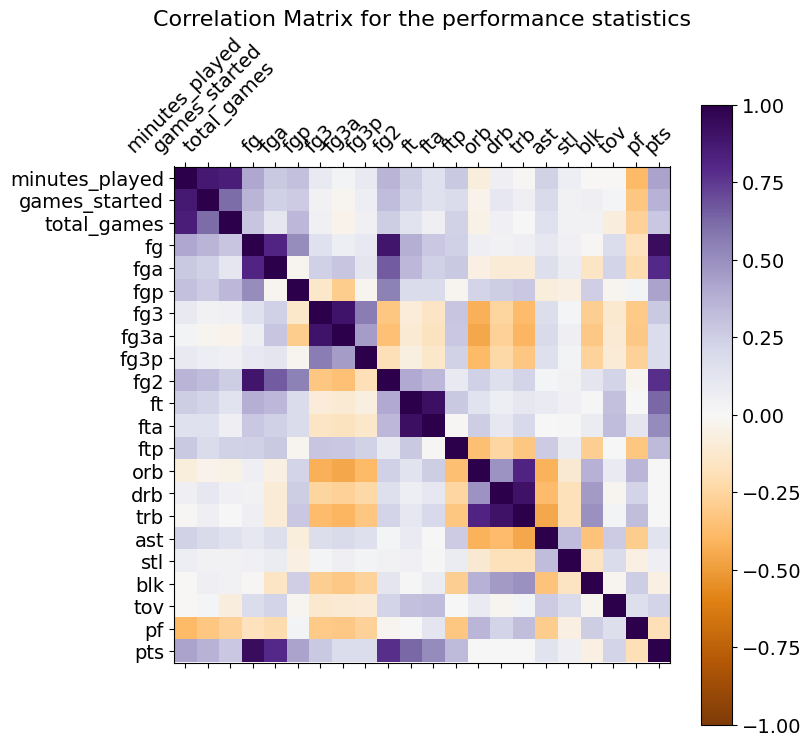

In [ ]:
f = plt.figure(figsize=(8, 8))
plt.matshow(sct_data.corr(), fignum=f.number, cmap=plt.get_cmap('PuOr'), vmin = -1, vmax = 1)
plt.xticks(range(sct_data.select_dtypes(['number']).shape[1]), sct_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(sct_data.select_dtypes(['number']).shape[1]), sct_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for the performance statistics', fontsize=16)
plt.show()

Finding the real cause of the missing values is the best method to reliable choose an imputation method. We noticed from the heatmap that many statistics are missing together, so the reasons lies rather in the nature of the collected data and not random technical issues. The amount of missing values also suggests that the values are missing not due to the players not scoring any point in the chosen statistics since they are professional NBA players. One possible explanation could be a difference in the data collection methods that were used in the different seasons, which results in incomplete data. This might be fairly easy to determine, so we plot the number of missing values per season below. 

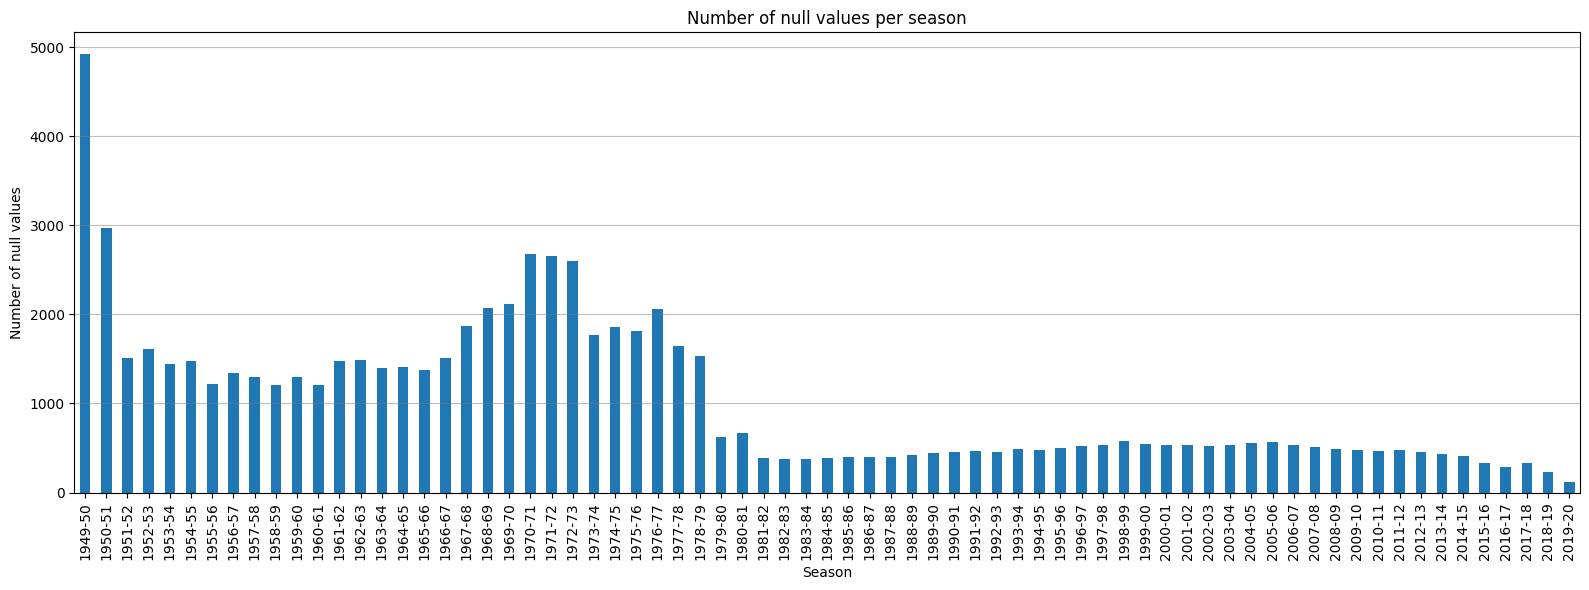

In [95]:
nulls_per_season = df_merged.groupby("season").apply(lambda x: x.isnull().sum())
nulls_per_season_total = nulls_per_season.sum(axis=1)

plt.figure(figsize=(16, 6))
nulls_per_season_total.plot(kind="bar")
plt.title("Number of null values per season")
plt.xlabel("Season")
plt.ylabel("Number of null values")
plt.xticks(rotation=90)
plt.grid(axis="y", color="gray", alpha=0.5)
plt.tight_layout()
plt.show()

We can observe three distinct timeframes where the null values appear to be at a comparable level:

1. From 1949 to 1951.
2. From 1951 to 1977.
3. From 1977 to 2019.

To explain this pattern, some domain knowledge is required. We foud out that these timeframes correlate with additional statistics being measured at the beginning of the 1951-1952 season (e.g., "pts" or "pf") and the start of the 1979-1980 season (e.g. "fg3"). The last change can be attributed to the introduction of the 3-point line. Before its introduction, three-pointers were not possible, and therefore not recorded. 

We have chosen to discard the data from 1949 to 1951 as it contains limited information. The remaining two timeframes will be divided into pre-3-point-line and post-3-point-line datasets. We want to further investigate those datasets. 

In [96]:
df_pre_3_point_line = df_merged.loc[(df_merged["season"]<"1979-80")&(df_merged["season"]>"1950-51")]
#drop the 3 point statistic as it is not relevant. Also drop the team_name as everyone is retired
df_pre_3_point_line.drop(columns=["fg3","fg3a","fg3p" ,"team_name"], inplace=True)

df_post_3_point_line =  df_merged.loc[df_merged["season"]>="1979-80"]
df_post_3_point_line

,name,full_name,position,weight,birth_date,birth_place,retired,teams,player_id,season,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
0,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1991-92,...,6.9,10.0,1.2,1.0,0.6,2.5,5.1,16.7,NaN,82
1,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1992-93,...,5.8,9.3,0.7,0.7,0.7,2.7,5.2,15.9,NaN,82
2,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1990-91,...,7.7,11.0,1.5,0.5,1.5,2.7,4.8,16.8,NaN,82
3,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1994-95,...,5.5,8.1,0.9,1.1,0.9,3.2,7.4,18.2,NaN,82
4,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1993-94,...,7.7,10.4,0.7,0.5,0.7,3.8,4.5,14.5,NaN,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21889,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[29],4814,2019-20,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,77
21890,Jeremiah Martin,Jeremiah Martin,PG,184.0,1996-01-19,"Memphis, Tennessee",False,[3],4817,2019-20,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
21891,William Howard,William Howard,F,205.0,1993-10-25,"Montbrison, France",False,"[29, 11]",4818,2019-20,...,5.5,5.5,2.8,0.0,0.0,2.8,2.8,0.0,Houston Rockets,80
21892,Gabe Vincent,Gabriel Nnamdi Vincent,PG,200.0,1996-06-14,"Modesto, California",False,"[26, 16]",4819,2019-20,...,2.6,2.6,2.6,0.9,0.0,0.0,1.8,10.5,Miami Heat,75


We can visualise this change in rules and how it affected our data. We create the same plot as before with different colors for the different datasets.

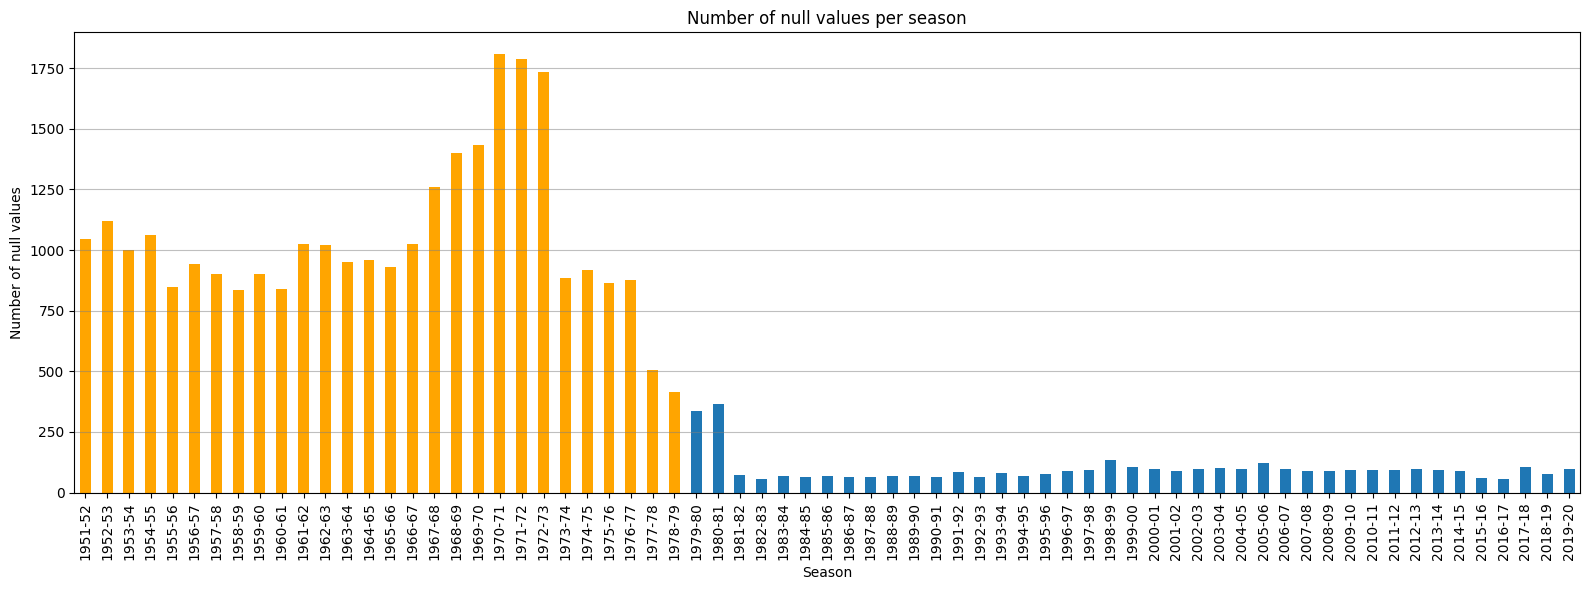

In [97]:
nulls_per_season_pre_3_point_line = df_pre_3_point_line.groupby("season").apply(lambda x: x.isnull().sum())
nulls_per_season_total_pre_3_point_line = nulls_per_season_pre_3_point_line.sum(axis=1)

nulls_per_season_post_3_point_line = df_post_3_point_line.drop(columns="team_name").groupby("season").apply(lambda x: x.isnull().sum()) # team_name is dropped for this comparision as there are many nulls included which will be handled later and therefore would skew the comparision.
nulls_per_season_total_post_3_point_line = nulls_per_season_post_3_point_line.sum(axis=1) 

series_helper = nulls_per_season_total_pre_3_point_line.copy() # is needed for the vis.
series_helper.values[:] = 0

series_helper = pd.concat((series_helper, nulls_per_season_total_post_3_point_line))



plt.figure(figsize=(16, 6))
nulls_per_season_total_pre_3_point_line.plot(kind="bar", color = "orange")
series_helper.plot(kind="bar")
plt.title("Number of null values per season")
plt.xlabel("Season")
plt.ylabel("Number of null values")
plt.xticks(rotation=90)
plt.grid(axis="y", color="gray", alpha=0.5)
plt.tight_layout()
plt.show()

It can be observed, that the pre-3-point-line dataset explains why more nulls per season than the post one. Since we want to compare the points scored, we will have to take the 3-point-rule into consideration. It would be unreasonable to compare the post-rule-introduction statistics with pre-rule-introduction because more point could be scored after. This is detrimental for effective data comparison and we want to focus on the most recent statistics. 
Therefore we decide for this exercise to only work with the post-3-point-line dataset, but save the other dataset for later use at it may be handy for exercise 2 or 3.

In [142]:
# save the old statistics
df_pre_3_point_line.to_csv("data/data_pre_3_point_line.csv", index =False)

We generate again a heatmap of null values to visually represent their distribution in the new post-3-line dataset

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

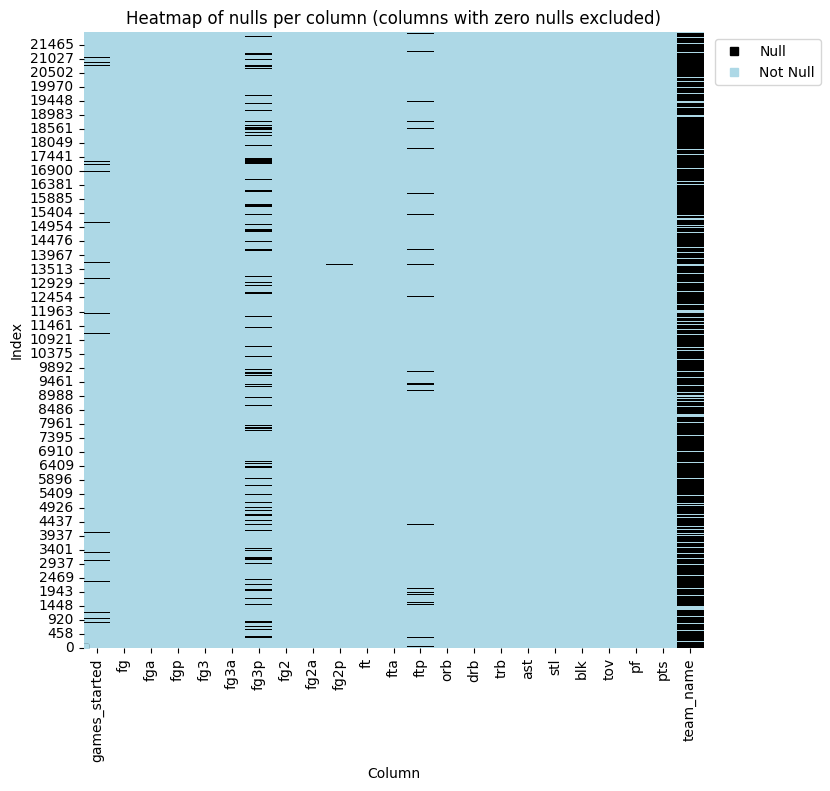

In [99]:
df_null_plot = df_post_3_point_line.loc[:, df_post_3_point_line.isnull().sum() != 0]

colors = ["lightblue", "black"]
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_null_plot.isnull(), cmap=colors, cbar=False)

plt.plot([0], label="Null", color=colors[1], marker="s", linestyle="")
plt.plot([0], label="Not Null", color=colors[0], marker="s", linestyle="")
legend = plt.legend(bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

### Handling Nulls in team_name

Missing value in the "team_name" means that the player currently has no team, since we chose "team_name" to represent only the current team of the player. Most cases can be explained by the "retired" column. So if the player is retired, their team will be assigned to "Retired". However, there are cases, in which a player is not retired but has no entry for the "current_team_id", so the missing values won't be handled by the default method.

As mentioned above, it is impossible to track, to which team each player belonged in which seasons, and for some cases, the "teams" column contains just an empty list. Judging by the "text" column that contains a short biography of each player, the players indeed played for some of the teams that are in the data, so assigning "Other" would be technically incorrect. Therefore, we decided to fill the other Nulls, of which there are relatively few, with "No Information".

There are no missing values in the "retired" column, so all cases must be covered accurately.

In [103]:
# fill the missing team names for the retired players
df_post_3_point_line.loc[df_post_3_point_line["retired"], "team_name"] = "Retired"
print(
    f"Number of players that have no team and are not retired: {len(df_post_3_point_line.loc[df_post_3_point_line["team_name"].isna()])}"
)

# fill other missing team names
df_post_3_point_line["team_name"].fillna("No Information", inplace=True)

Number of players that have no team and are not retired: 133


##### Handling the missing values in players' personal information
From the plot above we see that there are some entries where personal information of players such as weight, birth_date and birth_place are missing. 
We will handle them separately. 
- **weight**: there are no missing values in the "height" column, so we fill the missing values here with the average weight of the players' of the same height. For all different height values the corresponsing average weight values could be computed.
- **birth_date**: there is only one player with a missing birth_date, so we will fill his birth date manually.
- **birth_place**: this attribute is hard to fill accurately since it is a very specific piece of categorical data. There are also 331 misisng values, so it is not feasible to input them manually. Since we want to use the birth_place data for the visualization we would like it to be as accurate as possible. We noticed a pattern in the biographical "text" column that the first mention of a state is normally either a birth state or a high school state, where their basketball career begins. We will therefore fill the columns based on the first mentioned USA state. 

In [104]:
# create a dictionary {height: average weight}
height_to_weight = (
    df_merged[["height_inches", "weight"]]
    .groupby("height_inches")["weight"]
    .mean()
    .to_dict()
)
# fill the missing values in the weight column with the computed averages
df_merged["weight"] = df_merged["weight"].fillna(
    df_merged["height_inches"].map(height_to_weight)
)

# fill the only missing birth_date manually
df_merged["birth_date"].fillna(pd.to_datetime("1932-05-10"), inplace=True)

#### Handling the missing values in performance statistics

We will start by removing the rows that do not contain any relevant data about the players' statistics. Those are identifiable by the missing values in columns pts and fg (and fga), meaning there were no (attempted) field goals and no points scored.

There are only 3 rows that would be dropped so this method seems reasonable as it does not lose too much data. After removing these rows, we also do not see any missing values in the column minutes_played anymore, which might indicate that the players did not play those games or the data is missing entirely. Either way, this data is not useful for us.  

In [105]:
print(f"The number of rows with missing points (and field goals): {len(df_post_3_point_line.loc[(df_post_3_point_line["pts"].isnull())&(df_post_3_point_line["fg"].isnull())])}")
df_post_3_point_line.dropna(subset=["pts", "fg"], inplace = True)

The number of rows with missing points (and field goals): 3


The following columns will be filled with 0 for the following reasons:
- fgp: field goals percentage. This is a column that can be easily calculated like fg/fga. The technical issue here is that the Null values appear when fga = 0, and so fg = 0 as well. In this case, fgp will be logically 0 as well. 
- for the same reasons as above, fg3a, fg2a, fg3p, fg2p will be filled with 0 as well. 
- we observe the identical issue for free throws percentage (ftp) as for fgp, so we also fill it with 0.

In [106]:
df_post_3_point_line[["fgp", "fg3a", "fg2a", "fg3p", "fg2p", "ftp"]] = df_post_3_point_line[["fgp", "fg3a", "fg2a", "fg3p", "fg2p", "ftp"]].fillna(0)

We intentionally leave fg2 and fg3 Nulls in place because filling these stats with 0 would skew the average values in the data significantly. Since we already have the fg column without the missing values, it is best to rely on those values to deliver the total field goal information. In theory, field goals must contain both 2-point goals and 3-point goals.

We chose to fill the "games_started" column by finding the average percentage of games a player starts compared to the total games, and then multiplying that percentage by the total games given.

In [108]:
average_games_started = df_post_3_point_line["games_started"].sum()/df_post_3_point_line.loc[~df_post_3_point_line["games_started"].isna(), "total_games"].sum()


df_post_3_point_line["games_started"] = df_post_3_point_line["games_started"].fillna(
    np.round(df_post_3_point_line["total_games"] * average_games_started,0).astype(int)
)


,name,full_name,position,weight,birth_date,birth_place,retired,teams,player_id,season,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
0,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1991-92,...,6.9,10.0,1.2,1.0,0.6,2.5,5.1,16.7,Retired,82
1,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1992-93,...,5.8,9.3,0.7,0.7,0.7,2.7,5.2,15.9,Retired,82
2,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1990-91,...,7.7,11.0,1.5,0.5,1.5,2.7,4.8,16.8,Retired,82
3,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1994-95,...,5.5,8.1,0.9,1.1,0.9,3.2,7.4,18.2,Retired,82
4,Alaa Abdelnaby,Alaa Abdelnaby,F-C,240.0,1968-06-24,"Cairo, Egypt",True,"[25, 2, 26, 17, 23]",1,1993-94,...,7.7,10.4,0.7,0.5,0.7,3.8,4.5,14.5,Retired,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21889,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[29],4814,2019-20,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,77
21890,Jeremiah Martin,Jeremiah Martin,PG,184.0,1996-01-19,"Memphis, Tennessee",False,[3],4817,2019-20,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
21891,William Howard,William Howard,F,205.0,1993-10-25,"Montbrison, France",False,"[29, 11]",4818,2019-20,...,5.5,5.5,2.8,0.0,0.0,2.8,2.8,0.0,Houston Rockets,80
21892,Gabe Vincent,Gabriel Nnamdi Vincent,PG,200.0,1996-06-14,"Modesto, California",False,"[26, 16]",4819,2019-20,...,2.6,2.6,2.6,0.9,0.0,0.0,1.8,10.5,Miami Heat,75


#### Final check

Get the number of nulls in the dataset

In [113]:
print(f"Number of nulls in the dataset: {df_post_3_point_line.isnull().sum().sum()}")

Number of nulls in the dataset: 0


## Creating grouped tables
Create two new tables: one that groups rows based on player_id, another that groups rows based on team_id.

### Group by Player ID

While exploring the dataset we found that some players have two player-ids. This has to be fixed, as this id has to be unique for every player. 

Check for players which have two or more different player ids

In [115]:
def get_players_with_two_ids():
    df_players_with_two_ids = df_post_3_point_line.copy()
    df_players_with_two_ids = df_players_with_two_ids.drop_duplicates(
        subset=["player_id"]
    )

    array_player_names_with_two_ids = df_players_with_two_ids[
        df_players_with_two_ids.duplicated(subset=["full_name"])
    ]["full_name"].unique()

    df_players_with_two_ids = df_players_with_two_ids[
        df_players_with_two_ids["full_name"].isin(array_player_names_with_two_ids)
    ].sort_values("full_name")
    
    return df_players_with_two_ids


df_players_with_two_ids = get_players_with_two_ids()
df_players_with_two_ids.reset_index(drop=True)

,name,full_name,position,weight,birth_date,birth_place,retired,teams,player_id,season,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
0,Chris Wright,Chris Wright,F,226.0,1988-09-30,"Trotwood, Ohio",True,"[10, 17]",4740,2013-14,...,2.9,5.7,1.4,2.0,1.4,1.4,4.9,13.7,Retired,80
1,Chris Wright,Chris Wright,G,210.0,1989-11-04,"Washington, District of Columbia",True,[],4741,2012-13,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,18.0,Retired,73
2,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,[21],3643,2019-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
3,Isaiah Roby,Isaiah Roby,F,230.0,1998-02-03,"Dixon, Illinois",False,"[7, 21]",4811,2019-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma City Thunder,80
4,Jeremiah Martin,Jeremiah Martin,G,184.0,1996-06-19,"Memphis, Tennessee",False,[3],2702,2019-20,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
5,Jeremiah Martin,Jeremiah Martin,PG,184.0,1996-01-19,"Memphis, Tennessee",False,[3],4817,2019-20,...,3.3,3.3,3.3,3.3,0.0,0.0,0.0,6.5,Brooklyn Nets,75
6,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[23],3851,2019-20,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Philadelphia 76ers,77
7,Marial Shayok,Marial Shayok,G,196.0,1995-07-26,"Ottawa, Canada",False,[29],4814,2019-20,...,10.8,10.8,3.6,0.0,0.0,3.6,0.0,10.8,Utah Jazz,77
8,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],387,2019-20,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83
9,Marques Bolden,Marques Terrell Bolden,C,245.0,1998-04-17,"Dallas, Texas",False,[6],4820,2019-20,...,24.0,24.0,0.0,12.0,0.0,0.0,12.0,0.0,Cleveland Cavaliers,83


Decide for each player individually how to merge the two player instances:

- Ignore Chris Wrights and Micheal Smiths as they are obviously different persons

- Isaiah Roby: Drop the first entry as it's containing less info (teams)

- Jeremiah Martin: According to his wikipedia he played as PG in 2019-20. The position of the first entry will be changed and the second entry (has the wrong birth date), will be dropped.

- Marial Shayhok: According to the [NBA-Website](https://www.nba.com/stats/player/1629621/career) he only played for Philadelphia that season, so that row stays

- Marques  Bolden: Same info in both rows. First one stays

- William Howard: Drop the first entry as it's containing less info (teams)


In [117]:
df_post_3_point_line = df_post_3_point_line.loc[~(df_post_3_point_line["player_id"] == 3643)]
df_post_3_point_line = df_post_3_point_line.loc[~(df_post_3_point_line["player_id"] == 4817)]
df_post_3_point_line.loc[df_post_3_point_line["player_id"] == 2702, "position"] = "PG"
df_post_3_point_line = df_post_3_point_line.loc[~(df_post_3_point_line["player_id"] == 3851)]
df_post_3_point_line = df_post_3_point_line.loc[~(df_post_3_point_line["player_id"] == 4820)]
df_post_3_point_line = df_post_3_point_line.loc[~(df_post_3_point_line["player_id"] == 1951)]


get_players_with_two_ids()

,name,full_name,position,weight,birth_date,birth_place,retired,teams,player_id,season,...,drb,trb,ast,stl,blk,tov,pf,pts,team_name,height_inches
21713,Chris Wright,Chris Wright,F,226.0,1988-09-30,"Trotwood, Ohio",True,"[10, 17]",4740,2013-14,...,2.9,5.7,1.4,2.0,1.4,1.4,4.9,13.7,Retired,80
21715,Chris Wright,Chris Wright,G,210.0,1989-11-04,"Washington, District of Columbia",True,[],4741,2012-13,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,18.0,Retired,73
18199,Michael Smith,Michael John Smith,F,225.0,1965-05-19,"Rochester, New York",True,"[2, 13]",3973,1990-91,...,3.2,5.2,4.0,0.6,0.2,3.4,2.5,20.2,Retired,82
18202,Michael Smith,Michael John Smith,F,230.0,1972-03-28,"Washington, District of Columbia",True,"[26, 30]",3974,1995-96,...,6.4,10.1,2.9,1.2,1.2,1.9,4.3,9.3,Retired,80


Calculate the mean scoring stats over the players' whole career and their personal information. Since the data is calculated over the whole career, season is not included. Position can be included no p

In [124]:
scoring_agg = {
    "name": ["min"],    # categorical, here and later: use min to pick one entry because they are the same
    "team_name": ["min"], 
    "weight": ["mean"], 
    "height_inches": ["mean"], 
    "birth_date": ["min"],
    "birth_place": ["min"],
    "teams": ["min"], 
    "player_id" : ["min"], 
    "total_games" : ["mean"],
    "games_started" : ["mean"],
    "minutes_played": ["mean"],
    "fg3": [lambda x: np.mean(x) * 3],  # convert this stats to points scale
    "fg2": [lambda x: np.mean(x) * 2],  # convert this stats to points scale
    "fg": ["mean"],  # stat is already in the points scale
    "fg3a": ["mean"], 
    "fg2a": ["mean"], 
    "fg3p": ["mean"], 
    "fg2p": ["mean"], 
    "ft": ["mean"], # stat is already in the points scale
    "fta": ["mean"], 
    "ftp": ["mean"], 
    "fg3a": ["mean"], 
    "orb": ["mean"], 
    "drb": ["mean"], 
    "trb": ["mean"], 
    "ast": ["mean"], 
    "stl": ["mean"], 
    "blk": ["mean"], 
    "tov": ["mean"], 
    "pts": ["mean"],  # stat is already in the points scale
}

df_player_scoring_stats = (
    df_post_3_point_line.groupby(["player_id"]).agg(scoring_agg).reset_index(drop=True)
)
df_player_scoring_stats.columns = df_player_scoring_stats.columns.get_level_values(0)

columns_for_plot = [ "fg3", "fg2", "ft", "pts"]

- Choose the top 5 all-time leading scorers based on data from: https://www.nba.com/stats/alltime-leaders. This selection aids in addressing the ongoing debate surrounding the GOAT (Greatest of All Time) in basketball. Additionally, a smaller number of players results in a less cluttered plot.
- Calculate the averages for the relevant attributes in the dataset (points) to determine the average performance of players in NBA history and provide a basis for comparing the top 5 to an average player.

In [125]:
top_scorers = [
    "LeBron James",
    "Kareem Abdul-Jabbar",
    "Karl Malone",
    "Kobe Bryant",
    "Michael Jordan",
]

#choose the stats to plot
df_to_plot_pcp = df_player_scoring_stats[["name", "fg3", "fg2", "ft", "pts"]]

df_to_plot_pcp = df_to_plot_pcp[
    df_to_plot_pcp["name"].isin(top_scorers)
].sort_values("pts")


mean_per_column = df_player_scoring_stats[columns_for_plot].mean()
mean_df = pd.DataFrame([mean_per_column.values], columns=mean_per_column.index)
mean_df["name"] = "Player Average"

### Group by team name (team id)

Create a grouped DataFrame by team and season. Calculate the average points per 36 mins.

In [126]:
teams_agg = {
    "pts": ["mean"],
    "fg3": [lambda x: np.mean(x) * 3],  # convert this stats to points scale
    "fg2": [lambda x: np.mean(x) * 2],  # convert this stats to points scale
    "fg": ["mean"],  # stat is already in the points scale
    "fg3a": ["mean"], 
    "fg2a": ["mean"], 
    "fg3p": ["mean"], 
    "fg2p": ["mean"], 
    "ft": ["mean"], # stat is already in the points scale
    "fta": ["mean"], 
    "ftp": ["mean"], 
    "fg3a": ["mean"], 
    "orb": ["mean"], 
    "drb": ["mean"], 
    "trb": ["mean"], 
    "ast": ["mean"], 
    "stl": ["mean"], 
    "blk": ["mean"], 
    "tov": ["mean"], 
}

df_teams = df_post_3_point_line.groupby(["team_name", "season"]).agg(teams_agg).reset_index()
df_teams.columns = df_teams.columns.get_level_values(0)

Select only the latest season. This is necessary for linking a player's performance with their team's performance, which is feasible only for the most recent season. Typically, the current team corresponds to the team the player played for in the last season. However, there are occasional instances of players switching teams mid-season, which will be tolerated and not addressed further for the purpose of this exercise.

Additionally, exclude entries labeled as "Retired" or "No Information."

In [127]:
df_teams = (
    df_teams[df_teams["season"] == "2019-20"]
    .drop(columns="season")
    .reset_index(drop=True)
)

list_to_drop = ["Retired", "No Information"]
df_teams = df_teams[~df_teams["team_name"].isin(list_to_drop)]

## Visualization

### Plot graph based on player id

We create a parallel coordinates plot to illustrate the scoring performance across various statistics for the top 5 NBA players of all time based on points scored. This is done via pandas plotting, which builds on top of matplotlib. Therefore all matplotlib functioncs can be used to manipulate the plot.

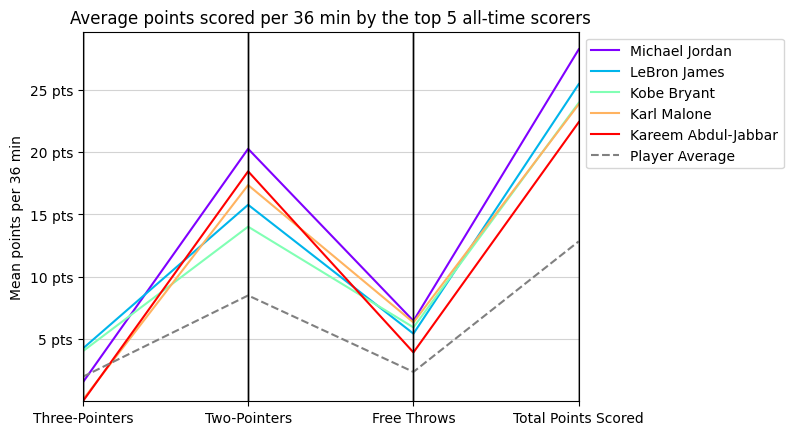

In [128]:
df_to_plot_pcp = df_to_plot_pcp[
    df_to_plot_pcp["name"].isin(top_scorers)
]

df_to_plot_pcp = df_to_plot_pcp.sort_values("pts", ascending=False)
ax = pd.plotting.parallel_coordinates(df_to_plot_pcp, "name", colormap="rainbow")
pd.plotting.parallel_coordinates(mean_df, "name", color="gray", linestyle="--")

ax.grid(axis="y", color="lightgray")

ax.set_xticklabels(
    ["Three-Pointers", "Two-Pointers", "Free Throws", "Total Points Scored"]
)

formatter = plt.FuncFormatter(
    lambda x, _: f"{int(x)} pts"
)  # Formatter to add "pts" to y tick labels
ax.yaxis.set_major_formatter(formatter)

ax.set_ylim(bottom=0.01)  # 0 Pts will not be plotted.
ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel("Mean points per 36 min")
ax.set_title("Average points scored per 36 min by the top 5 all-time scorers")
plt.show()

**Description of the plot:**
- The plot illustrates the top 5 all-time scorers in the NBA, detailing their average points per 36 minutes across different scoring methods. Additionally, it includes the average performance of NBA players for comparison.

- Across the board, the bulk of points for these top players comes from Two-Pointers, followed by Free Throws, and then Three-Pointers, indicating a consistent trend among them.

- The graph illustrates the points scored per 36 minutes and the breakdown of scoring methods for the top 5 all-time scorers, averaged across each player's entire career.

- Michael Jordan appears to be the greatest scorer per 36 minutes of all time. However, he is only an average three-point shooter, excelling instead at two-pointers and free throws.

- Kareem Abdul-Jabbar and Karl Malone are both terrible three-point shooters, falling well below average. 

- Kareem Abdul-Jabbar's real strength seems to be two-pointers, where he is very close to Michael Jordan. 

- It's worth noting that half of Kareem Abdul-Jabbar's career (1969–1989) is not included in the dataset due to the cutoff at the 1979-1980 season.

- LeBron James seems like a great all-rounder. His three-pointers are the best among the top 5, and in no category is he the worst player. 

- Kobe Bryant is also a great three-point shooter, but compared to the others, his weakness lies in two-pointers.


### Visualisation 2 using bokeh: Bar chart for scored points based by each team

In [129]:
# create a copy of the df_teams to modify for the plot 
teams_pts_plot = df_teams

# Dict to map the primary colors to the team names
nba_team_primary_colors = {
    "Atlanta Hawks": "#E03A3E",
    "Boston Celtics": "#007A33",
    "Brooklyn Nets": "#000000",
    "Charlotte Hornets": "#00788C",
    "Chicago Bulls": "#CE1141",
    "Cleveland Cavaliers": "#860038",
    "Dallas Mavericks": "#00538C",
    "Denver Nuggets": "#0E2240",
    "Detroit Pistons": "#C8102E",
    "Golden State Warriors": "#1D428A",
    "Houston Rockets": "#CE1141",
    "Indiana Pacers": "#002D62",
    "Los Angeles Clippers": "#C8102E",
    "Los Angeles Lakers": "#552583",
    "Memphis Grizzlies": "#5D76A9",
    "Miami Heat": "#98002E",
    "Milwaukee Bucks": "#00471B",
    "Minnesota Timberwolves": "#0C2340",
    "New Orleans Pelicans": "#0C2340",
    "New York Knicks": "#006BB6",
    "Oklahoma City Thunder": "#007AC1",
    "Orlando Magic": "#0077C0",
    "Philadelphia 76ers": "#006BB6",
    "Phoenix Suns": "#1D1160",
    "Portland Trail Blazers": "#E03A3E",
    "Sacramento Kings": "#5A2D81",
    "San Antonio Spurs": "#C4CED4",
    "Toronto Raptors": "#CE1141",
    "Utah Jazz": "#002B5C",
    "Washington Wizards": "#002B5C",
}

#Dict to map the short names to the team names
nba_teams_short = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BKN",
    "Charlotte Hornets": "CHA",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}

# Create a new column for the mapping
teams_pts_plot["color"] = teams_pts_plot["team_name"].map(nba_team_primary_colors)
teams_pts_plot["short_team_names"] = teams_pts_plot["team_name"].map(nba_teams_short)

# Create a column which contains the legend entries
teams_pts_plot["legend"] = teams_pts_plot["short_team_names"] + " - " + teams_pts_plot["team_name"]

# Sort DataFrame
teams_pts_plot = teams_pts_plot.sort_values("pts", ascending=False)


# Define the source
source = ColumnDataSource(data=teams_pts_plot)

# Define the figure
p = figure(
    title="Average Points per Player per 36 Minutes per Team in the 2019-20 NBA Season",
    x_range=teams_pts_plot["short_team_names"],
    height=800,
    width=1100,
)


# Create a ColorMapper to map the primary colors to bars
color_mapper = CategoricalColorMapper(
    factors=teams_pts_plot["team_name"].unique(), palette=teams_pts_plot["color"]
)

# Add a legend. Important to have that bit before the p.vbar. Otherwise legend will be on top of plot
p.add_layout(Legend(), "right")

# Plot bar plot
p.vbar(
    x="short_team_names",
    top="pts",
    width=0.5,
    bottom=0,
    source=source,
    color={"field": "team_name", "transform": color_mapper},
    legend_field="legend",
)

# Create a hovering tool
hover = HoverTool(tooltips=[("Team", "@team_name"), ("Points", "@pts")])
p.add_tools(hover)

# Adjust the legend
p.legend.label_text_font_size = "9pt"
p.legend.glyph_height = 10
p.legend.glyph_width = 10

# Adjust the y starting valze
p.y_range.start = 0

p.xaxis.major_label_orientation = 120

# Add a format to the y-ticks
p.yaxis.formatter = tick_formatter = CustomJSTickFormatter(
    code="""
    return tick + " pts";
    """
)


# Plot the graph
output_notebook()
show(p)

Loading BokehJS ...

**Description of the plot:**
- The graph illustrates the average number of points a player would score per 36 minutes for their respective team during the 2019-20 Season.

- It is interactive; hovering over it displays the full team name and the precise average points.

- The color of the bar corresponds to the primary color of the team, so it should be easy for NBA fans to find their favourite teams on the plot.

- The bar chart is arranged in descending order from the highest average to the lowest point count to enable easier comparison of teams.

- On average, the Los Angeles Clippers' coach could anticipate their players scoring more points in 36 minutes than any other team, so the average LA Clipper's player is better than an average player of another team. Moreover, the gap to the second-ranked team is significant at 1.5 points.

- However, it wasn't the Los Angeles Clippers but the Los Angeles Lakers who were the champions that year, despite having the third worst average. The Miami Heat, the second finalist, only ranked 20th in terms of average points per player per 36 minutes. This suggests that there is no perfect correlation between a team's average performance per player per 36 minutes and their success in the championship.

## Saving the results
Saving the resulting tables (the cleaned player_data_per_36_min and the two new aggregated tables) as CSV.

In [141]:
# save the prepared dataset with players statistics
df_merged.to_csv('data/player_stats_36_min.csv', index=False)  

# save the post-3-point-line dazasez
df_post_3_point_line.to_csv('data/data_post_3_point_line.csv', index=False)  

# save the aggregated player table
df_player_scoring_stats.to_csv('data/agg_player_scoring_stats.csv', index=False)  
# save the aggregated team table
df_teams.to_csv('data/agg_teams.csv', index=False)  

# Bonus!
Map done based on df_merged. Not for grading but it is fun.

In [132]:
birth_places = df_merged["birth_place"].unique()

In [133]:
df_merged["birth_states"] = df_merged["birth_place"].str.split(",", expand=True)[1]
df_merged["birth_states"] = df_merged["birth_states"].apply(
    lambda x: str(x).replace("\xa0", "")
)

In [134]:
all_states = pd.Series(df_merged["birth_states"].unique())

In [135]:
US_states = [
    "Alabama",
    "Alaska",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "Florida",
    "Georgia",
    "Hawaii",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "North Dakota",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Vermont",
    "Virginia",
    "Washington",
    "West Virginia",
    "Wisconsin",
    "Wyoming",
]

US_state_to_code = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

In [136]:
df_merged_US = df_merged.loc[df_merged["birth_states"].isin(US_states)]
df_merged_US["state_code"] = df_merged_US["birth_states"].map(US_state_to_code)

In [137]:
np.setdiff1d(US_states, all_states[pd.Series(all_states).isin(US_states)].unique())

array(['Vermont'], dtype='<U14')

In [138]:
df_merged_US_map = (
    df_merged_US[["birth_states", "state_code", "player_id"]]
    .groupby(["state_code", "birth_states"])
    .count()
    .reset_index()
)

In [139]:
# add Vermont to the table for completeness
df_merged_US_map = pd.concat(
    [
        df_merged_US_map,
        pd.DataFrame([{"state_code": "VT", "birth_states": "Vermont", "player_id": 0}]),
    ],
    ignore_index=True,
)

In [140]:
fig = px.choropleth(
    df_merged_US_map,
    locations="state_code",
    locationmode="USA-states",
    scope="usa",
    color="player_id",
    color_continuous_scale="Blues",
    hover_name="birth_states",
)

fig.update_layout(geo=dict(showlakes=False))

fig.add_scattergeo(
    locations=df_merged_US_map["state_code"],
    locationmode="USA-states",
    text=df_merged_US_map["state_code"],
    mode="text",
    hoverinfo="skip",
)

fig.update_layout(
    title={
        "text": "Number of NBA players born in each US state",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    }
)